# FACET-II Particle Transverse Wake Instability Stages Tests

Ben Chen, 7 October 2023, University of Oslo

## Import OPAL framework and required classes

In [1]:
import sys
sys.path.append('../')
from opal import *
import numpy as np

from scipy.constants import c, e, m_e, epsilon_0 as eps0
from opal.utilities.relativity import energy2gamma

# Enable the widget backend for interactive plots
%matplotlib widget

# Sets the seed for the pseudo-random number generator in Python to obtain the same sequence of random numbers.
np.random.seed(42) 

[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation


initializing ocelot...
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


## Settings and definitions

In [22]:
# Determines whether the results of the tracking should be overwritten.
overwrite = False

# Determines whether to use interstages in the tracking. Currently also need to comment out some lines in interstage_basic.py.
use_interstages = False

# Determines whether to save plots
save_plots = True

# Determines the DPI value the figures are saved to
save_fig_dpi = 600

# Number of stages in the linac.
num_stages = 3

# Set the default DPI
plt.rcParams['figure.dpi'] = 100

# Set default font sizes for figures
import matplotlib.pylab as pylab
params = {
    #'figure.figsize': (15, 5),
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12
}
pylab.rcParams.update(params)

# Set the figure size to fit within the notebook cell
#plt.rcParams['figure.figsize'] = [.1, .1]  # Adjust these values as needed

# Set various paths
notebook_name = 'FACETII_prtcl_instability_stage_tests'
path_sep = os.sep
#upload_dir = '/scratch/project_465000445/jianbinb/uploaded/'
upload_dir = '/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/OPAL/uploaded/'  # Path for local machine.
current_dir = os.path.abspath('')  # Get the current file's directory name.
diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep

## Define the input beams
Same parameters as in /QUICKPIC/2019-03-20_FACET-II_parameters_longSim_gamma195690

In [3]:
# Define drive beam
driver = SourceBasic()
driver.charge = -e * 1.0e10  # [C]
driver_gamma = 195690.0
driver.energy = gamma2energy(driver_gamma)  # [eV]
driver.rel_energy_spread = 0.01*0
driver.bunch_length = 12.77e-6  # [m]
driver.z_offset = 60.0664e-6  # [m]
driver.emit_nx, driver.emit_ny = 5.0e-5, 5.0e-5  # [m rad]
driver_sigma_x = 2.05e-6  # [m]
driver_sigma_y = 2.05e-6  # [m]
driver.beta_x = driver_sigma_x**2/driver.emit_nx*driver_gamma  # [m]
driver.beta_y = driver_sigma_y**2/driver.emit_ny*driver_gamma  # [m]
driver.num_particles = 10000
#driver.wallplug_efficiency = 0.5


# Define main beam
main = SourceBasic()
main.charge = -e * 3.33e9  # [C]
main_gamma = 195690.0
main.energy = gamma2energy(main_gamma)  # [eV]
main.rel_energy_spread = 0.00005
main.bunch_length = 6.38e-06  # [m]
main.emit_nx, main.emit_ny = 5.0e-5, 5.0e-5  # [m rad]
main_sigma_x = 2.05e-6  # [m]
main_sigma_y = 2.05e-6  # [m]
main.beta_x = main_sigma_x**2/main.emit_nx*main_gamma  # [m]
main.beta_y = main_sigma_y**2/main.emit_ny*main_gamma  # [m]
#main.beta_x = stage.matched_beta_function(main.energy)
main.num_particles = 6000
main.z_offset = -49.7777e-6  # [m]
main.x_offset =  3.649e-06  # [m]
main.y_offset =  0.5*main_sigma_y  # [m]
main.symmetrize = False
#main.wallplug_efficiency = 0.1
#main.accel_gradient = 7.11e9  # [V/m]

## Define the linac

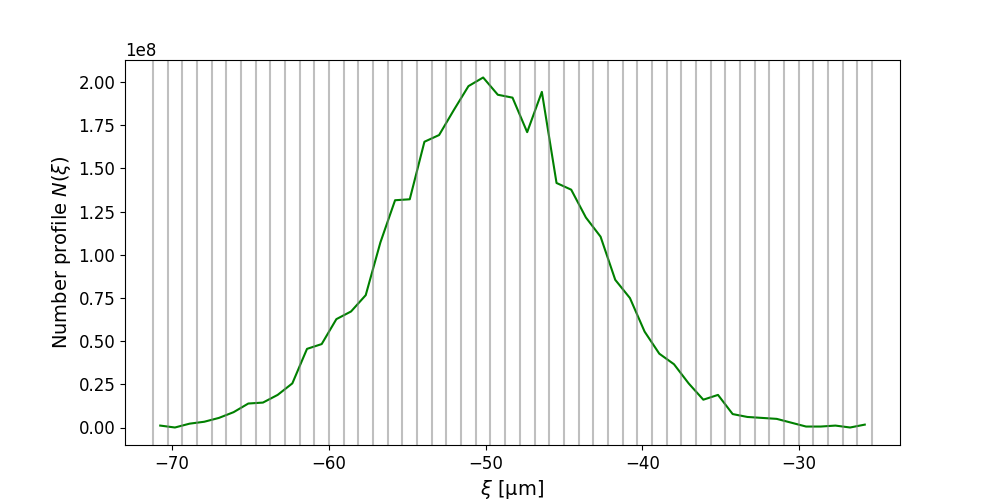

In [4]:
############# Define the first stage #############
stage = StagePrtclTransWakeInstability()
stage.length = 3.318147/num_stages  # [m]
stage.time_step_mod = 0.02
stage.nom_energy_gain = 23.5e9/3  # [eV]
stage.plasma_density = 4e22  # [m^-3]
stage.driver_source = driver
stage.main_source = main
drive_beam = stage.driver_source.track()  # Convert a Source object to a Beam object.
main_beam = stage.main_source.track()  # Convert a Source object to a Beam object.
stage.drive_beam = drive_beam
stage.main_beam = main_beam
stage.diag_path = current_dir + path_sep + 'run_data' + path_sep + notebook_name + path_sep

# ========== Beam slice parameters ==========
main_beam_roi = np.max(np.abs(main_beam.zs()))/main_beam.bunch_length()*1.5  # Specifies the region of interest in units of main beam sigma_z (rms bunch length).
stage.main_beam_roi = main_beam_roi
#cut_off = stage.main_beam_roi*main.bunch_length
#stage.beam_length_roi = 2*cut_off  # [m] total bunch/beam length.  old name: tot_beam_length

# Freedman–Diaconis rule for determining the beam slice thickness
num_beam_slice = stage.FD_rule_num_slice()
stage.num_beam_slice = num_beam_slice

# Number profile N(z). Dimensionless, same as dN/dz with each bin multiplied with the width of the slices.
main_num_profile, z0s_main_cut = stage.longitudinal_number_distribution(beam=stage.main_beam, make_plot=True)  # uniform_bins=False allows for thicker slices towards beam head.
stage.main_num_profile = main_num_profile
stage.z_slices = z0s_main_cut
#num_beam_slice = len(z0s_main_cut)
#stage.num_beam_slice = num_beam_slice

driver_num_profile, zs_driver_cut = stage.longitudinal_number_distribution(beam=stage.drive_beam)
stage.driver_num_profile = driver_num_profile
stage.zs_driver_cut = zs_driver_cut

# Initial main beam slice x-offsets, energies and x'-offsets
#stage.x_slices_main = stage.particles2slices(beam=stage.main_beam, beam_quant=stage.main_beam.xs(), z_slices=stage.z_slices, make_plot=False)
#stage.xp_slices_main = stage.particles2slices(beam=stage.main_beam, beam_quant=stage.main_beam.xps(), z_slices=stage.z_slices, make_plot=False)
#stage.y_slices_main = stage.particles2slices(beam=stage.main_beam, beam_quant=stage.main_beam.ys(), z_slices=stage.z_slices, make_plot=False)
#stage.yp_slices_main = stage.particles2slices(beam=stage.main_beam, beam_quant=stage.main_beam.yps(), z_slices=stage.z_slices, make_plot=False)
#stage.energy_slices_main = stage.particles2slices(beam=stage.main_beam, beam_quant=stage.main_beam.Es(), z_slices=stage.z_slices, make_plot=False)

s_init = stage.z_slices
x0s_main = stage.main_beam.xs()


############# Define interstages #############
if use_interstages is True:
    interstage = InterstageBasic()
    interstage.beta0 = lambda energy: stage.get_matched_beta_function(energy)
    interstage.dipole_length = lambda energy: 1 * np.sqrt(energy/10e9)  # [m(eV)], energy-dependent length
    interstage.dipole_field = 0.5 # [T]  (0-2)T
else:
    interstage = InterstageNull()
stage.interstage_dipole_field = interstage.dipole_field


############# Define linac #############
linac = Linac(source=main, stage=stage, interstage=interstage, num_stages=num_stages)

In [5]:
stage.print_initial_summary(drive_beam, main_beam)

Time step [betatron wavelength/c]:			 0.020
Interstages enabled:					 False
Interstage dipole field:				 0.000
Symmetrised main beam:					 False
Symmetrised drive beam:					 False

Stage length [m]:					 1.106
Plasma density [m^-3]:					 4.000e+22
Drive beam x jitter (std) [um]:				 0.000
Drive beam y jitter (std) [um]:				 0.000
----------------------------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Number of macro particles:			 10000			 6000
Initial beam population:			 1.000e+10 		 3.330e+09
Initial mean gamma:				 195690.000 		 195690.076
Initial mean energy [GeV]:			 99.997 		 99.997
Initial rms energy spread [%]:			 0.000 			 0.005

Initial beam x offset [um]:			 -0.004 		 3.689
Initial beam y offset [um]:			 -0.026 			 1.039
Initial beam z offset [um]:			 60.149 		 -49.741

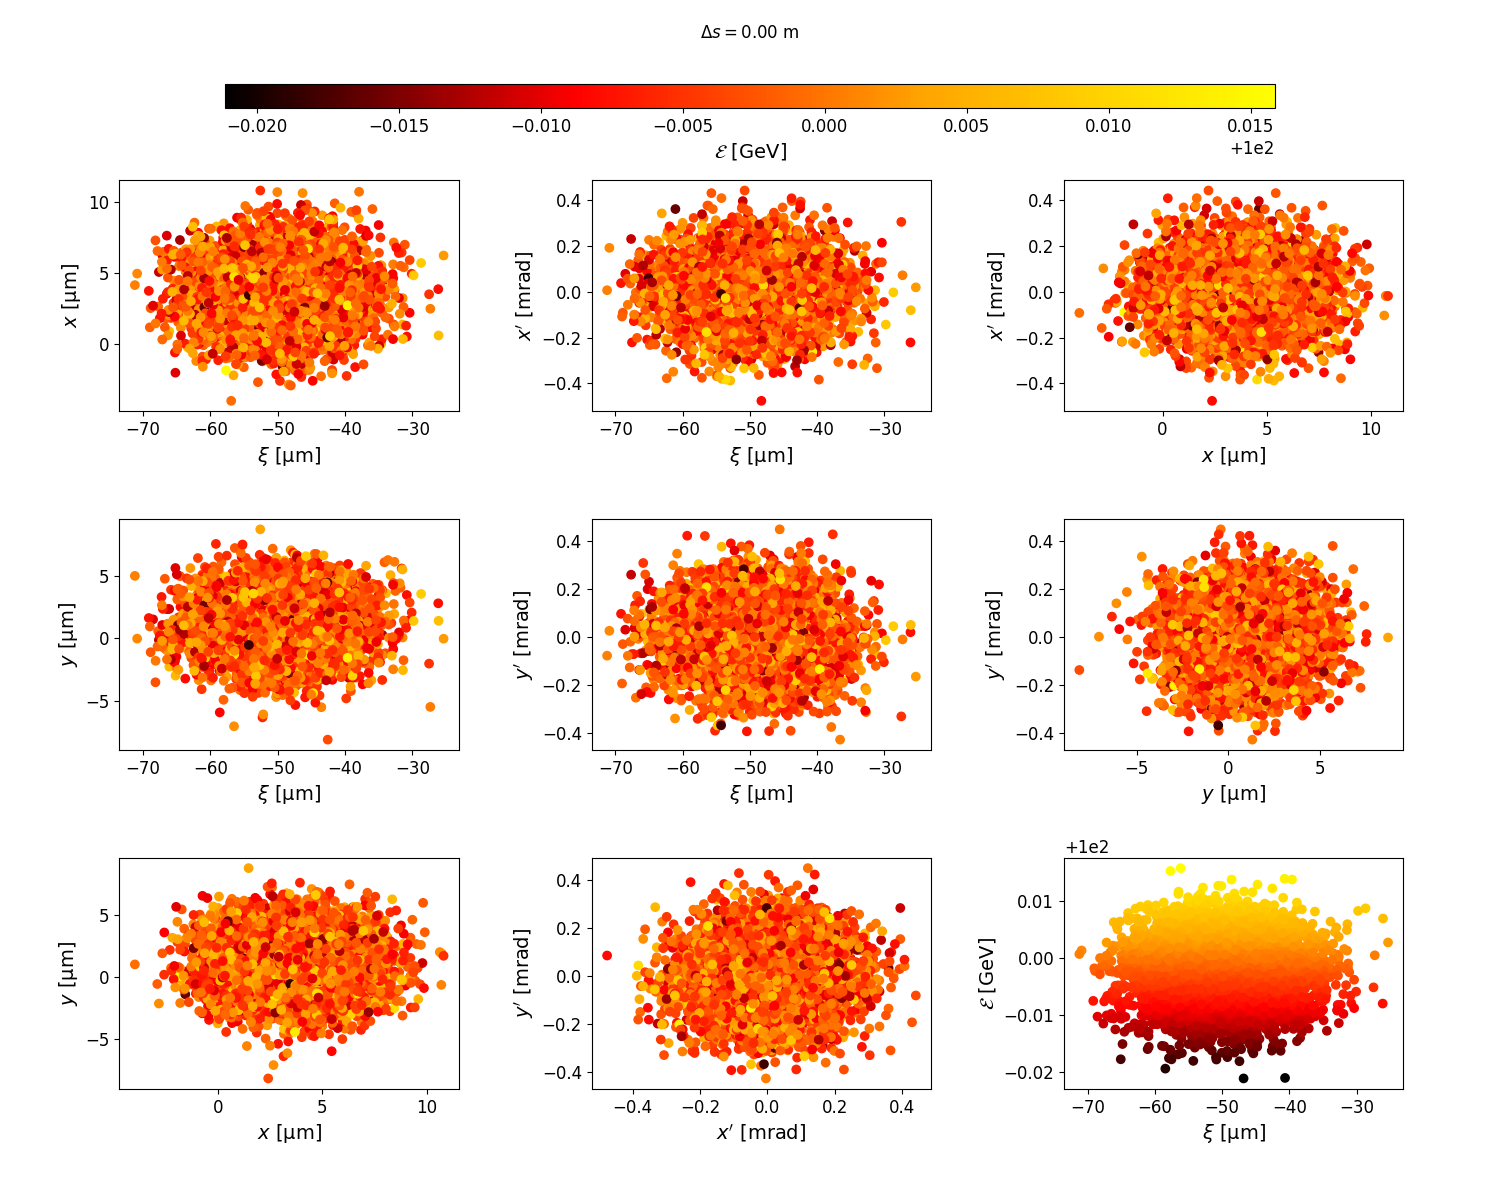

In [6]:
stage.scatter_diags(beam=stage.main_beam, plot_centroids=False, n_th_particle=1)

## Calculate input longitudinal field, plasma bubble radius and longitudinal number profile with Wake-T

In [7]:
# Define a Wake-T stage
stage_wakeT = StageWakeT()
stage_wakeT.driver_source = driver
k_beta = k_p(stage.plasma_density)/np.sqrt(2*min(main_beam.gamma(),drive_beam.gamma()/2))
lambda_betatron = (2*np.pi/k_beta)
stage_wakeT.length = lambda_betatron/10  # [m]
stage_wakeT.plasma_density = stage.plasma_density  # [m^-3]
stage_wakeT.box_min_z = -115.0e-6
stage_wakeT.box_max_z = 115.0e-6
#stage_wakeT.box_size_r = 240.5e-6
stage_wakeT.opmd_diag = True  # Set to True for saving simulation results.
stage_wakeT.diag_dir = stage.diag_path + 'wake_t'

# Run the Wake-T stage
beam_copy = copy.deepcopy(stage.main_beam)
beam_wakeT = stage_wakeT.track(beam_copy)

# Read the simulation data
path = stage_wakeT.diag_dir + path_sep + 'hdf5'
ts = OpenPMDTimeSeries(path)

Plasma stage: 100%|█████████████████████████████████████████████| 0.007385/0.007385 m [00:00]


/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Software/opal_env/lib/python3.10/site-packages/aptools/data_analysis/beam_diagnostics.py:524: RuntimeWarning: invalid value encountered in sqrt
  em_x = np.sqrt(np.linalg.det(cov_x.astype(np.float32, copy=False)))


### Extract data

In [8]:
iteration = 0
dump_time = ts.t[iteration]


# Extract macroparticle coordinates
xs_main, zs_main, weights_main = ts.get_particle(species='beam', iteration=iteration, var_list=['x', 'z', 'w'], plot=False)
xs_driver, zs_driver, weights_driver = ts.get_particle(species='driver', iteration=iteration, var_list=['x', 'z', 'w'], plot=False)
zs_beams = np.append(zs_driver, zs_main)
xs_beams = np.append(xs_driver, xs_main)


# Extract transverse fields
Ex, info_Ex = ts.get_field(field='E', coord='x', iteration=iteration, plot=False)
By, info_By = ts.get_field(field='B', coord='y', iteration=iteration, plot=False)
Ex_cBy = Ex - c*By
zs_Ex = info_Ex.z
rs_Ex = info_Ex.r


# Extract longitudinal E-field
Ez_wakeT, info_Ez = ts.get_field(field='E', coord='z', iteration=iteration, plot=False)
#dir(info_Ez)
zs_Ez_wakeT = info_Ez.z
rs_Ez = info_Ez.r
# Extract axial longitudinal E-field
Ez_axis_wakeT = Ez_wakeT[round(len(info_Ez.r)/2),:]


# Extract plasma charge density
rho, info_rho = ts.get_field(field='rho', iteration=iteration, plot=False)
# Calculate the number density
plasma_num_density = rho/stage_wakeT.plasma_density/-e
# Extract coordinates
zs_rho = info_rho.z
rs_rho = info_rho.r


# Extract the plasma bubble radius
bubble_radius_wakeT = stage.get_bubble_radius(plasma_num_density, rs_rho, threshold=0.8)


# Re-calculate number density profiles for the iteration
Nbins = int(np.sqrt(len(zs_driver)/2))
bins = np.linspace(np.min(zs_driver), np.max(zs_driver), Nbins)
counts, edges = np.histogram(zs_driver, weights=weights_driver*e, bins=bins)
zs_dNdz_driver_wakeT = (edges[0:-1] + edges[1:])/2
dNdz_driver_wakeT = counts/np.diff(edges)/e
xi_dNdz_driver_wakeT = zs_dNdz_driver_wakeT - c*dump_time

Nbins = int(np.sqrt(len(zs_main)/2))
bins = np.linspace(np.min(zs_main), np.max(zs_main), Nbins)
counts, edges = np.histogram(zs_main, weights=weights_main, bins=bins)
zs_dNdz_main_wakeT = (edges[0:-1] + edges[1:])/2
dNdz_main_wakeT = counts/np.diff(edges)
xi_dNdz_main_wakeT = zs_dNdz_main_wakeT - c*dump_time

### Make plots

[]

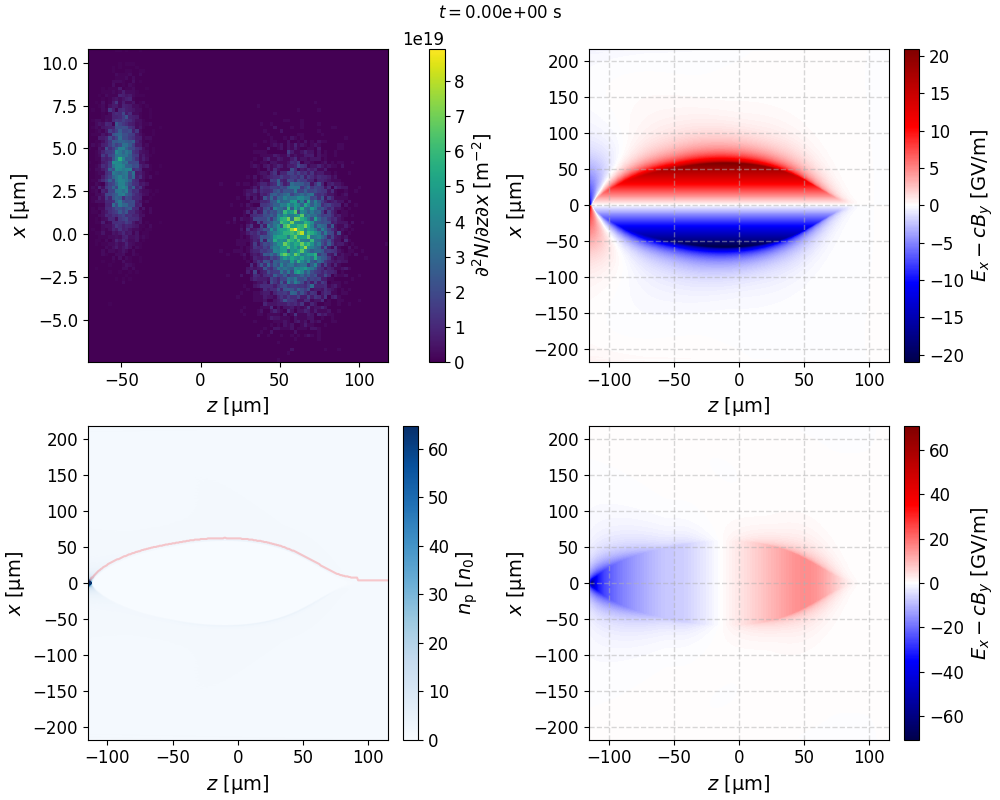

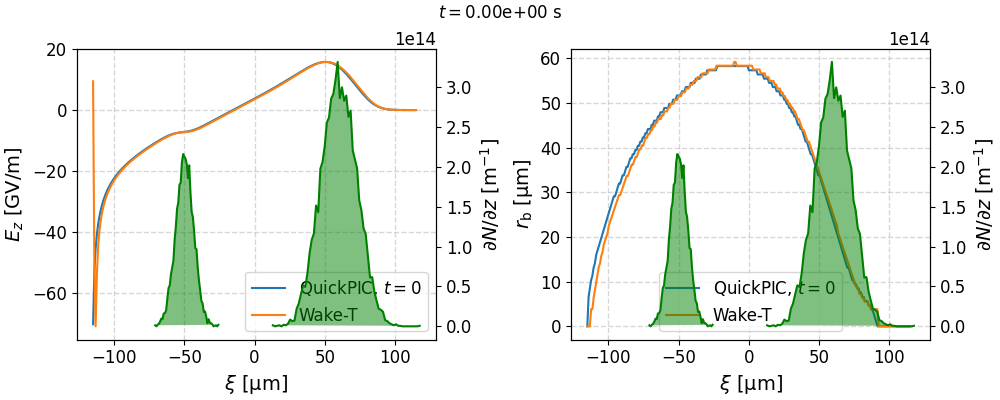

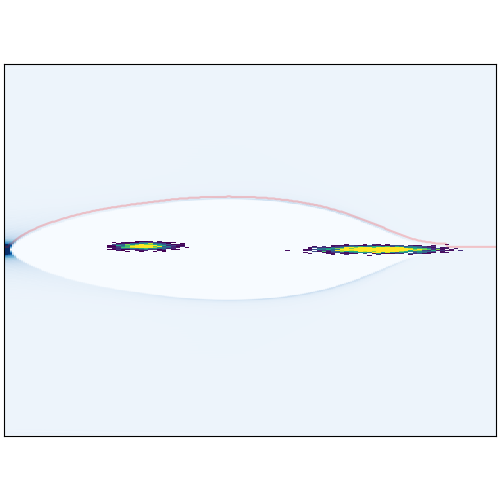

In [9]:
# Close all open figures
#plt.close('all')

# Get slider and figures (requires widget backend for interactive plots)
#ts.slider()

# Labels for plots
zlab = '$z$ [$\mathrm{\mu}$m]'
xilab = r'$\xi$ [$\mathrm{\mu}$m]'
#slab = '$s$ [m]'
xlab = '$x$ [$\mathrm{\mu}$m]'
field_lab = '$E_z$ [GV/m]'
dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'
#xps_lab = '$x\'$ [mrad]'
#energ_lab = '$\mathcal{E}$ [GeV]'

# Set up a figure with axes
fig_wakeT, axs_wakeT = plt.subplots(nrows=2, ncols=2, layout="constrained", figsize=(10, 4*2))
fig_wakeT.suptitle('$t=$' f'{format(dump_time, ".2e")}' ' s')


# Plot the bunches
w = weights_driver
w = np.append(weights_driver, weights_main)  # The weights for the macroparticles. Append in same order as zs_beams.
nbins = int(np.sqrt(len(w)/2))
hist_bins = [ nbins, nbins ]  # list of 2 ints. Number of bins along each direction, for the histograms
hist_range = [[None, None], [None, None]]
hist_range[0] = [ zs_beams.min(), zs_beams.max() ]  # [m], list contains 2 lists of 2 floats. Extent of the histogram along each direction
hist_range[1] = [ xs_beams.min(), xs_beams.max() ]
extent_beams = hist_range[0] + hist_range[1]
extent_beams = [i*1e6 for i in extent_beams]  # [um]
binned_data, zedges, xedges = np.histogram2d(zs_beams, xs_beams, hist_bins, hist_range, weights=w)
beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
#beam_hist2d = binned_data.T; clab = '$N(z,x)$'
stage.imshow_plot(beam_hist2d, axes=axs_wakeT[0][0], extent=extent_beams, vmin=None, vmax=None, colmap='viridis', 
                  xlab=zlab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')

# Plot the transverse fields
extent = [zs_Ex.min(), zs_Ex.max(), rs_Ex.min(), rs_Ex.max()]
extent = [i*1e6 for i in extent]  # [um]
stage.imshow_plot(Ex_cBy/1e9, axes=axs_wakeT[0][1], extent=extent, vmin=Ex_cBy.min()/1e9, vmax=-Ex_cBy.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')


# Plot the plasma number density
cmap_max = np.min(rho)/stage_wakeT.plasma_density/-e*0.0141
cmap_min = np.max(rho)/stage_wakeT.plasma_density/-e
rho_extent = [zs_rho.min(), zs_rho.max(), rs_rho.min(), rs_rho.max()]
rho_extent = [i*1e6 for i in rho_extent]  # [um]
stage.imshow_plot(plasma_num_density, axes=axs_wakeT[1][0], extent=rho_extent, vmin=cmap_min, vmax=cmap_max, colmap='Blues', xlab=zlab, ylab=xlab, clab='$n_\mathrm{p}$ [$n_0$]', gridOn=False, origin='lower')
axs_wakeT[1][0].plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)


# Plot the longitudinal electric field
extent = [zs_Ez_wakeT.min(), zs_Ez_wakeT.max(), rs_Ez.min(), rs_Ez.max()]
extent = [i*1e6 for i in extent]  # [um]
stage.imshow_plot(Ez_wakeT/1e9, axes=axs_wakeT[1][1], extent=extent, vmin=Ez_wakeT.min()/1e9, vmax=-Ez_wakeT.min()/1e9, colmap='seismic', xlab=zlab, ylab=xlab, clab='$E_x-cB_y$ [GV/m]', gridOn=True, origin='lower')


# Set up a figure with axes
fig_wakeT2, axs_wakeT2 = plt.subplots(nrows=1, ncols=2, layout="compressed", figsize=(10, 4))
fig_wakeT2.suptitle('$t=$' f'{format(dump_time, ".2e")}' ' s')


# Extract uploaded QuickPIC data for comparison
QP_path =  upload_dir + '/2019-03-20_FACET-II_parameters_longSim_gamma195690_rb_Ez.csv'
QP_dat = np.genfromtxt(QP_path, delimiter=',', skip_header=True)
xi_rb_QP = QP_dat[:,0]
rb_QP = QP_dat[:,1]
xi_Ez_QP = QP_dat[:,2]
Ez_QP = QP_dat[:,3]

# Plot longitudinal axial E-field
axs_wakeT2[0].plot(xi_Ez_QP*1e6, Ez_QP/1e9, label='QuickPIC, $t=0$')
axs_wakeT2[0].plot((zs_Ez_wakeT-c*dump_time)*1e6, Ez_axis_wakeT/1e9, label='Wake-T')
axs_wakeT2[0].legend()
axs_wakeT2[0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[0].set_xlabel(xilab)
axs_wakeT2[0].set_ylabel(field_lab)
ax = axs_wakeT2[0].twinx()
ax.fill(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g')
ax.fill(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g')
ax.set_ylabel(dN_dz_lab)


# Plot the plasma bubble radius
axs_wakeT2[1].plot(xi_rb_QP*1e6, rb_QP*1e6, label='QuickPIC, $t=0$')
axs_wakeT2[1].plot((zs_rho-c*dump_time)*1e6, bubble_radius_wakeT*1e6, label='Wake-T')
axs_wakeT2[1].legend()
axs_wakeT2[1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
axs_wakeT2[1].set_xlabel(xilab)
axs_wakeT2[1].set_ylabel('$r_\mathrm{b}$ [$\mathrm{\mu}$m]')
ax = axs_wakeT2[1].twinx()
ax.fill(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g')
ax.fill(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g', alpha=0.5)
ax.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g')
ax.set_ylabel(dN_dz_lab)


# Plot Beam and plasma
fig_bp, ax_bp = plt.subplots(nrows=1, ncols=1, layout="compressed", figsize=(5, 5))
cmap = plt.cm.viridis
cmap.set_bad(color='white')
beam_hist2d[beam_hist2d < 1e2] = np.nan # boolean masking
ax_bp.imshow(plasma_num_density, extent=rho_extent, vmin=0, vmax=20, cmap='Blues', origin='lower', interpolation='nearest', aspect=0.4)
ax_bp.plot(zs_rho*1e6, (bubble_radius_wakeT+main.x_offset)*1e6, 'r', alpha=0.2)
ax_bp.imshow(beam_hist2d, extent=extent_beams, vmin=None, vmax=2.5e19, cmap='viridis', origin='lower', interpolation='nearest', aspect=0.4)
ax_bp.set_xlim(rho_extent[0], rho_extent[1])
ax_bp.set_ylim(rho_extent[2], rho_extent[3])
ax_bp.set_yticks([]); ax_bp.set_yticklabels([]); ax_bp.set_xticks([]); ax_bp.set_xticklabels([])
#fig_bp.savefig('Wake-T_beam_plasma.pdf', format='pdf', dpi=300, bbox_inches='tight', transparent=False)


#stage_wakeT.plot_evolution()
#beam_wakeT.plot_lps()

In [10]:
#test = np.sum(beam_hist2d*np.diff(xedges), axis=0)
#print(np.sum(test*np.diff(zedges)))
#
#plt.figure()
#plt.plot(zedges[0:-1]*1e6, test)
#plt.plot(xi_dNdz_main_wakeT*1e6, dNdz_main_wakeT, 'g', alpha=0.5)
#plt.plot(xi_dNdz_driver_wakeT*1e6, dNdz_driver_wakeT, 'g', alpha=0.5)
#
#
## Plot some transverse slices of the plasma number density
#plt.figure()
#rows, cols = np.shape(plasma_num_density)
##plt.plot(plasma_num_density[round(rows/2), 3:-1])
#idx_plasma_slice = round(cols/2)
#plt.plot(plasma_num_density[:,idx_plasma_slice], label='$z=$' f'{format(zs_rho[idx_plasma_slice]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice+50], label='$z=$' f'{format(zs_rho[idx_plasma_slice+50]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice+75], label='$z=$' f'{format(zs_rho[idx_plasma_slice+75]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice+100], label='$z=$' f'{format(zs_rho[idx_plasma_slice+100]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-50], label='$z=$' f'{format(zs_rho[idx_plasma_slice-50]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-75], label='$z=$' f'{format(zs_rho[idx_plasma_slice-75]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-100], label='$z=$' f'{format(zs_rho[idx_plasma_slice-100]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#plt.plot(plasma_num_density[:,idx_plasma_slice-120], label='$z=$' f'{format(zs_rho[idx_plasma_slice-120]*1e6, ".1f")}' ' $\mathrm{\mu}$m')
#
#plt.grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)
#plt.xlabel('Index')
#plt.ylabel('$n_\mathrm{p}$ [$n_0$]')
#plt.title('$t=$' f'{format(dump_time, ".2e")}' ' s')
#plt.legend()

## Perform tracking

In [11]:
linac.run(notebook_name, overwrite=overwrite)

>> SHOT 1 already exists and will not be overwritten.


In [12]:
shot_num = 0
stage_num = 2
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.
#beam_out = linac[shot_num].get_beam(-2)

## Plot outputs

### Cut-out bubble radius, longitudinal E-field and longitudinal beam profile

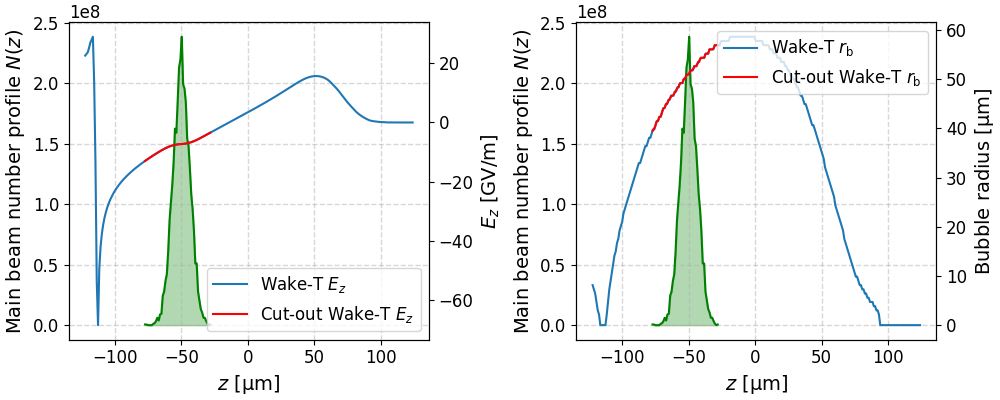

In [13]:
stage_tracked.plot_Ez_rb_cut()

### Beam slice plots

In [14]:
#stage_tracked.slice_offset_s_diag(beam=beam_out)

In [15]:
#stage_tracked.centroid_snapshot_plots(beam=beam_out)

### Beam particle plots

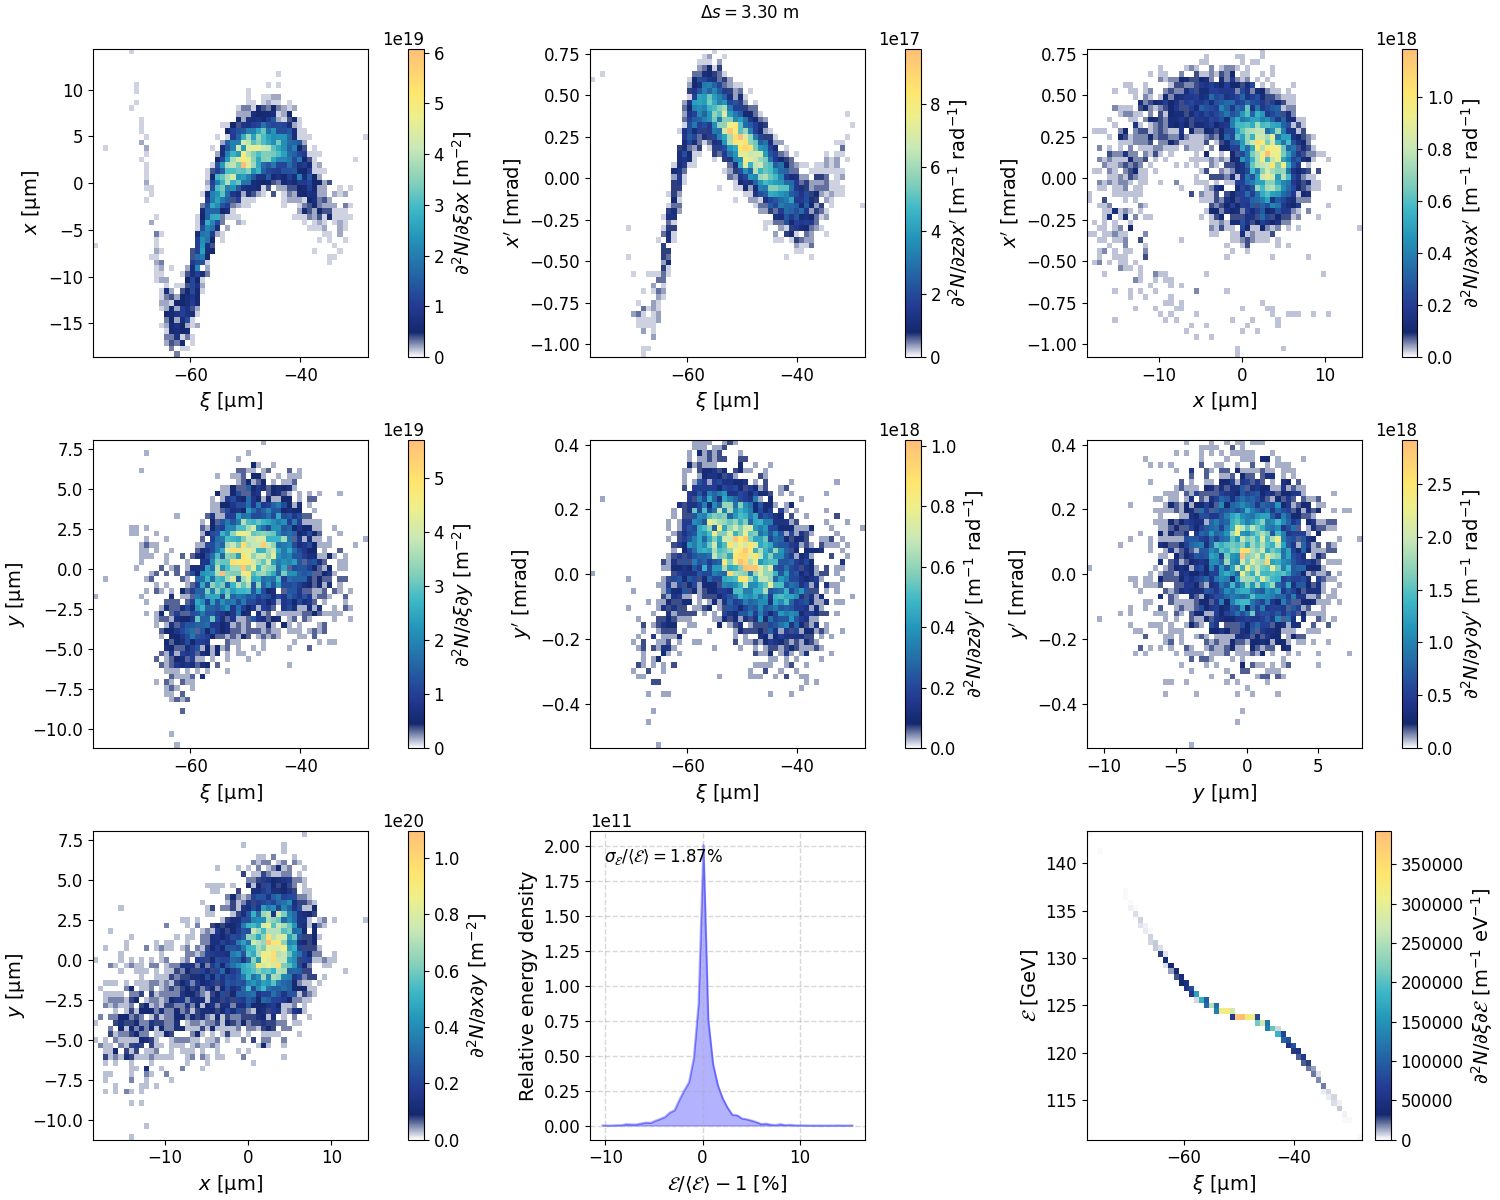

In [16]:
plot_stage = stage_tracked

# Set up override to plot other stages
#plot_stage = linac[shot_num].stages[1]  # Get a specific acceleration stage in a linac. Zero indexing.

plot_stage.density_map_diags(beam=beam_out, plot_centroids=False)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'densMaps_FACET-II_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    else:
        filename = stage_tracked.diag_path + 'densMaps_FACET-II_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

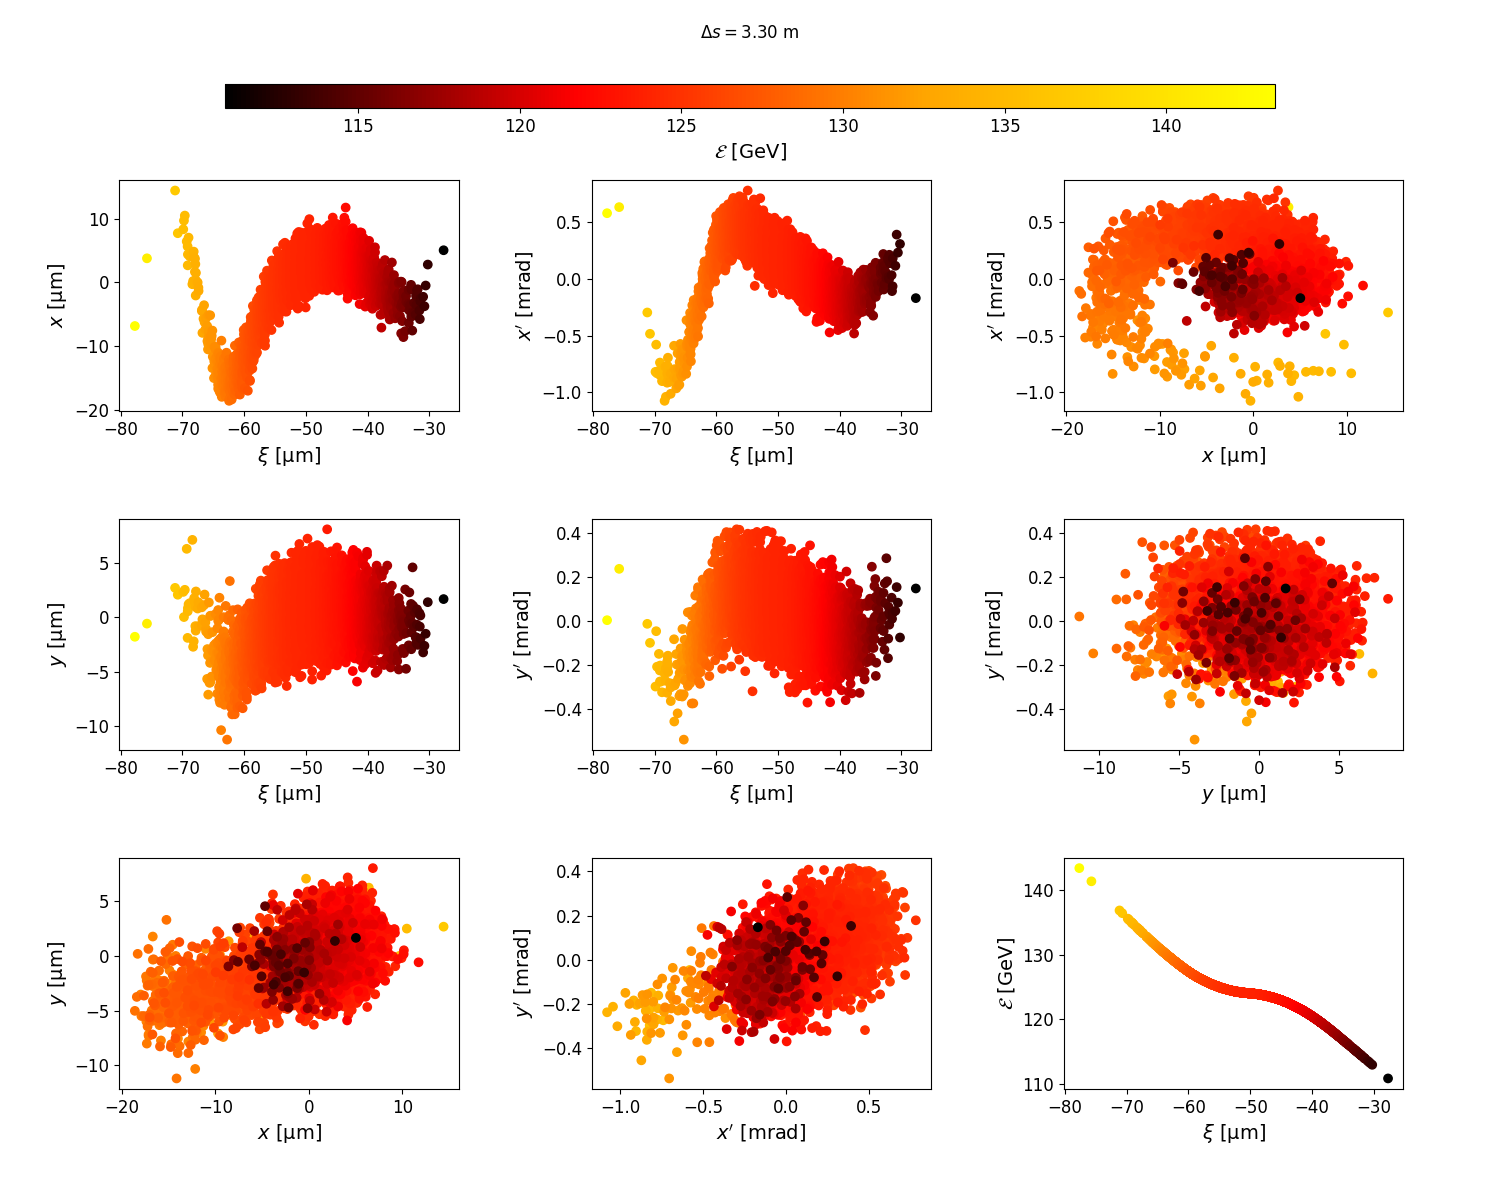

In [17]:
plot_stage = stage_tracked

# Set up override to plot other stages
#plot_stage = linac[shot_num].stages[1]  # Get a specific acceleration stage in a linac. Zero indexing.

plot_stage.scatter_diags(beam=beam_out, plot_centroids=False, n_th_particle=1, show_slice_grid=False, plot_k_beta=False)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'scatter_FACET-II_' + 'prtclInstabilityStage' + str(stage_num) + '_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.png'
    else:
        filename = stage_tracked.diag_path + 'scatter_FACET-II_' + 'prtclInstabilityStage' + str(stage_num) + '_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt.png'
    plt.savefig(filename, format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

## Plot beam evolution and survey

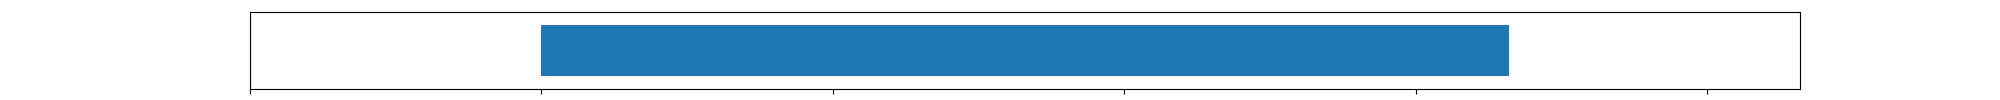

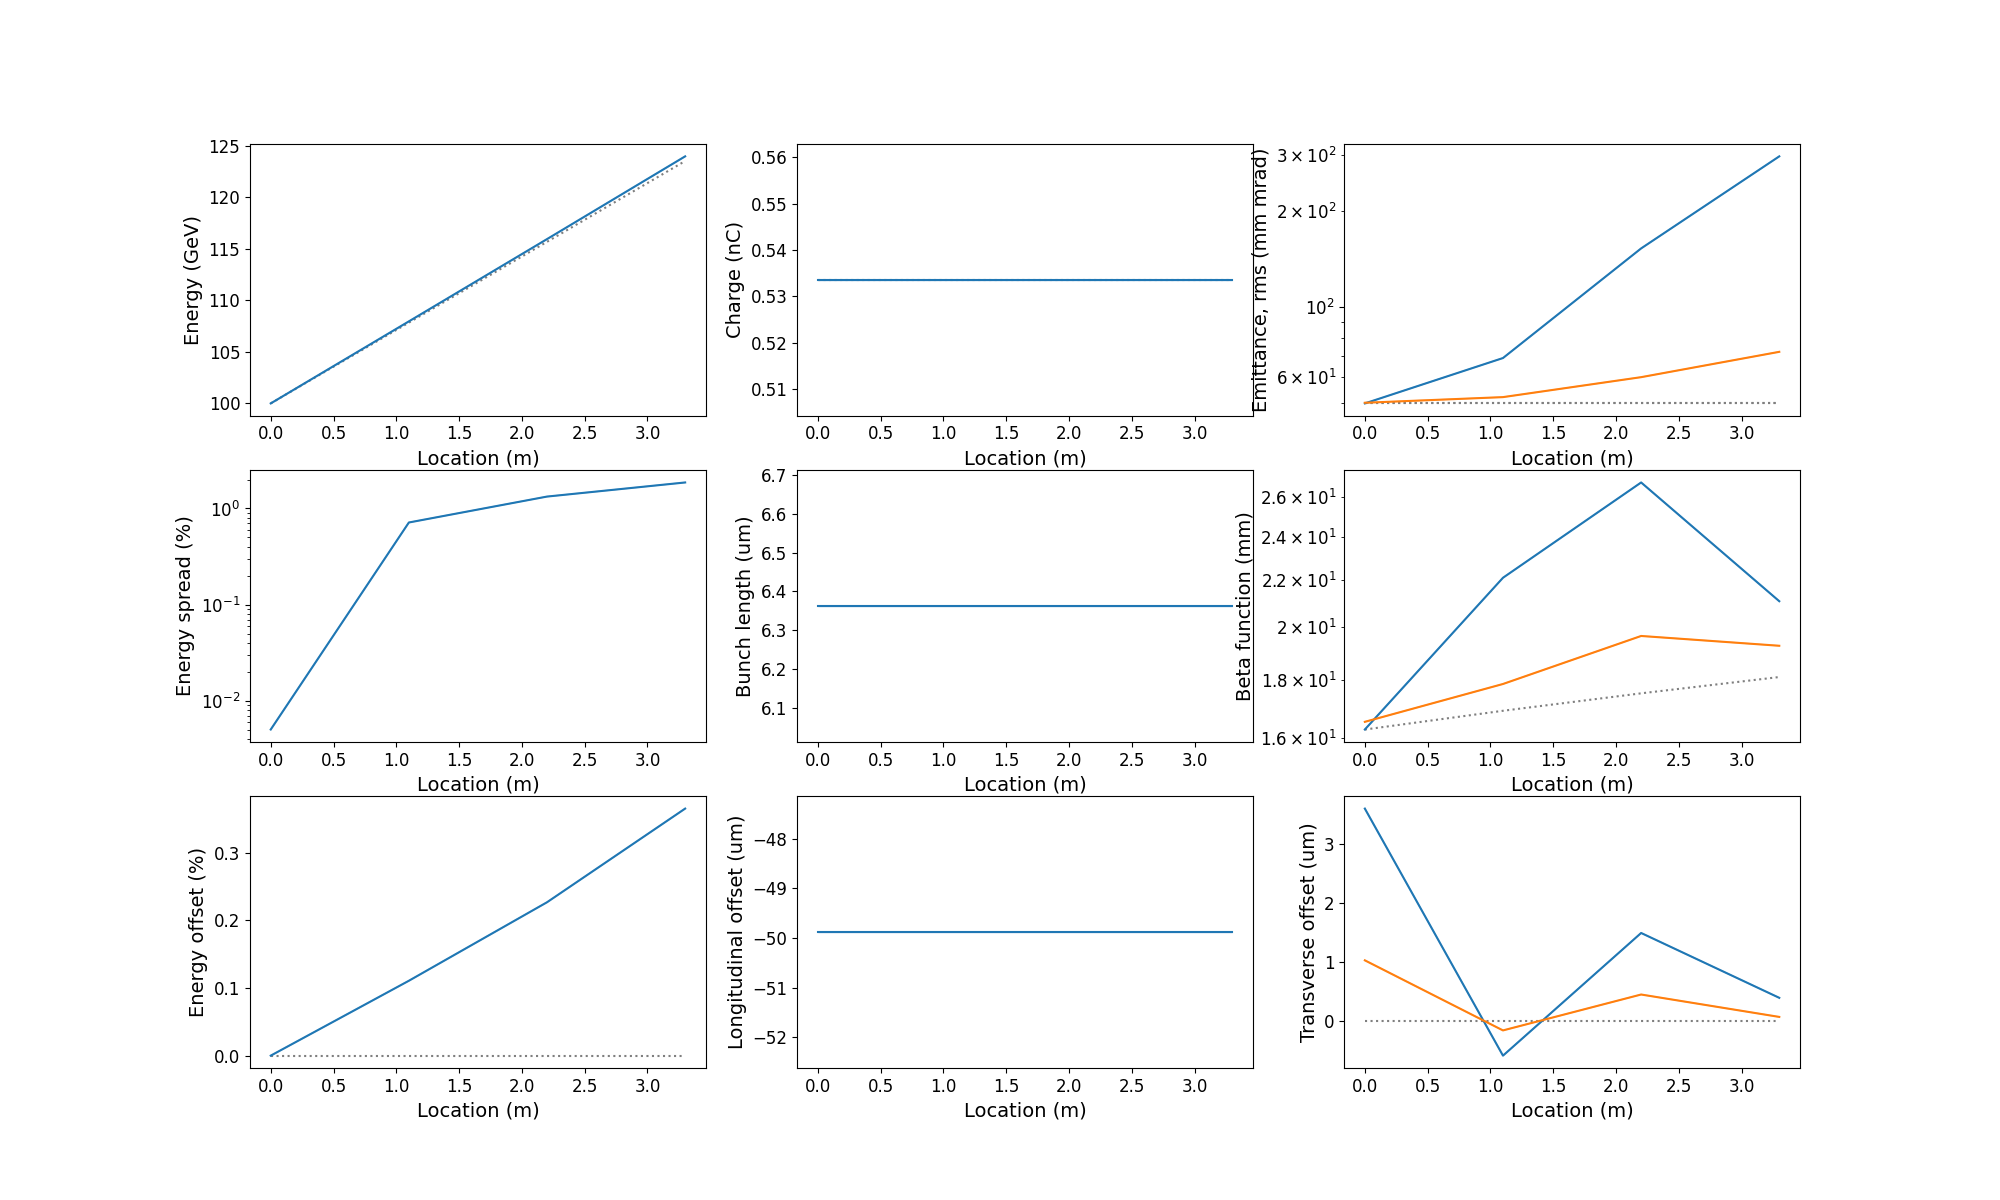

In [18]:
# plot linac survey
linac.plot_survey()

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'sketch_evolution_FACET-II_' + str(num_stages) + 'prtclInstabilityStages_interstages'
    else:
        filename = stage_tracked.diag_path + 'sketch_evolution_FACET-II_' + str(num_stages) + 'prtclInstabilityStages'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)


# plot beam evolution
linac.plot_evolution()

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'evolution_FACET-II_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    else:
        filename = stage_tracked.diag_path + 'evolution_FACET-II_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    plt.savefig(filename+'.pdf', format='pdf', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

In [19]:
stage_tracked.print_current_summary(drive_beam, main_beam, beam_out)

Time step [betatron wavelength/c]:	 0.020
Interstages enabled:			 False
Interstage dipole field:		 0.000
Symmetrised main beam:			 False
Symmetrised drive beam:			 False

Stage length [m]:			 1.100
Propagation length [m]:			 3.300
Plasma density [m^-3]:			 4.000e+22
Drive beam x jitter (std) [um]:		 0.000
Drive beam y jitter (std) [um]:		 0.000
---------------------------------------------------

-------------------------------------------------------------------------------------
Quantity 					 Drive beam 		 Main beam
-------------------------------------------------------------------------------------
Initial number of macro particles:		 10000			 6000
Current number of macro particles:		  			 6000
Initial beam population:			 1.000e+10 		 3.330e+09
Current beam population:			 	 		 3.330e+09

Current mean gamma:				 	 		 242561.806
Initial mean energy [GeV]:			 99.997 		 99.997
Current mean energy [GeV]:			 	 		 123.949
Initial rms energy spread [%]:			 0.000 			 0.005
Current rms ener

## QuickPIC beam data

In [20]:
%run /Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/Dropbox/Documents/UiO/Codes/JupyterNotebooks/TransverseInstability/QuickPICWrapper.py
datadir_QP = '/Users/ben_c/Library/CloudStorage/OneDrive-UniversitetetiOslo/CERN/QUICKPIC/2019-03-20_FACET-II_parameters_longSim_gamma195690/'

n0, omega_p, lambda_p, k_p, scale_E, scale_B, scale_rho = calc_global_scales(datadir_QP)
qp = QPWrapper(datadir_QP, filename='rpinput', last_extract_step=415)

Extracting dump step 1/416.
Extracting dump step 2/416.
Extracting dump step 3/416.
Extracting dump step 4/416.
Extracting dump step 5/416.
Extracting dump step 6/416.
Extracting dump step 7/416.
Extracting dump step 8/416.
Extracting dump step 9/416.
Extracting dump step 10/416.
Extracting dump step 11/416.
Extracting dump step 12/416.
Extracting dump step 13/416.
Extracting dump step 14/416.
Extracting dump step 15/416.
Extracting dump step 16/416.
Extracting dump step 17/416.
Extracting dump step 18/416.
Extracting dump step 19/416.
Extracting dump step 20/416.
Extracting dump step 21/416.
Extracting dump step 22/416.
Extracting dump step 23/416.
Extracting dump step 24/416.
Extracting dump step 25/416.
Extracting dump step 26/416.
Extracting dump step 27/416.
Extracting dump step 28/416.
Extracting dump step 29/416.
Extracting dump step 30/416.
Extracting dump step 31/416.
Extracting dump step 32/416.
Extracting dump step 33/416.
Extracting dump step 34/416.
Extracting dump step 35

131071
6000


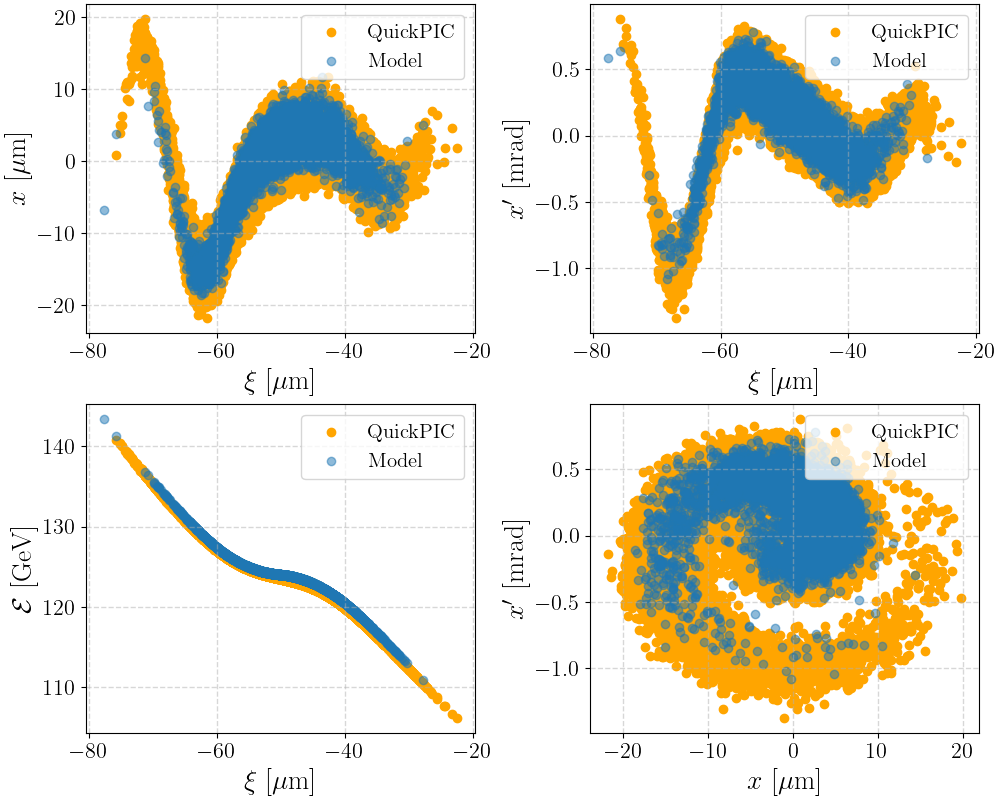

In [24]:
extract_step = -1
main_QP = qp[extract_step].PP[1].beam

# Set default Latex fonts
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set default font sizes for figures
params = {
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 15
}
pylab.rcParams.update(params)

# Labels for plots
#zlab = '$z$ [$\mathrm{\mu}$m]'
#xilab = r'$\xi$ [$\mathrm{\mu}$m]'
#slab = '$s$ [m]'
#xlab = '$x$ [$\mathrm{\mu}$m]'
#field_lab = '$E_z$ [GV/m]'
#dN_dz_lab = '$\partial N/\partial z$ [$\mathrm{m}^{-1}$]'
xps_lab = '$x\'$ [mrad]'
energ_lab = '$\mathcal{E}$ [GeV]'


# ---------- Convert grid coordinates ----------
# Scale grid coordinates such that the beam moves to the right and the beam axis is in the middle of the box.
xs_main_QP = (main_QP[:,0] - qp.offset_x0) * 1e-6  # [m]

xis_main_QP = -(main_QP[:,2] - qp.offset_z0) * 1e-6  # [m]
xps_main_QP = main_QP[:,3] * 1e-6  # [rad]
Es_main_QP = main_QP[:,5] * 1e9  # [eV]
weights_QP = qp._qp_N[1]/len(xs_main_QP) * np.ones(len(xs_main_QP))  # The weight of each macro particle for the mein beam.

# Set up a figure with axes
fig_QP_beam, axs_QP_beam = plt.subplots(nrows=2, ncols=2, layout='constrained', figsize=(10, 4*2))

# 2D z-x distribution
#binned_data, zedges, xedges = np.histogram2d(xis_main_QP, xs_main_QP, hist_bins, hist_range, weights=weights_QP)
#beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
##beam_hist2d = binned_data.T; clab = '$N(z,x)$'
#stage_tracked.imshow_plot(beam_hist2d, axes=axs_QP_beam[0][0], extent=extent, vmin=None, vmax=None, colmap='viridis', 
#                  xlab=xilab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
#axs_QP_beam[0][0].plot(stage.zs_main_cut*1e6, x_slices*1e6, 'r', alpha=0.5)


# 2D z-x' distribution
#binned_data, zedges, xedges = np.histogram2d(xis_main_QP, xps_main_QP, hist_bins, hist_range, weights=weights_QP)
#beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial z\partial x$ [$\mathrm{m}^{-2}$]'
##beam_hist2d = binned_data.T; clab = '$N(z,x)$'
#stage_tracked.imshow_plot(beam_hist2d, axes=axs_QP_beam[0][1], extent=extent_xxp, vmin=None, vmax=None, colmap='viridis', 
#                  xlab=xilab, ylab=xlab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')
#axs_QP_beam[0][1].plot(stage.zs_main_cut*1e6, xp_slices*1e3, 'r', alpha=0.5)


# 2D x-x' distribution
#binned_data, zedges, xedges = np.histogram2d(xs_main_QP, xps_main_QP, hist_bins, hist_range_xxp, weights=weights_QP)
#beam_hist2d = binned_data.T/np.diff(zedges)/np.diff(xedges); clab = '$\partial^2 N/\partial x\partial x\'$ [$\mathrm{m}^{-1}$ $\mathrm{rad}^{-1}$]'
##beam_hist2d = binned_data.T; clab = '$N(z,x)$'
#stage_tracked.imshow_plot(beam_hist2d, axs_QP_beam[1][1], extent=extent_xxp, vmin=None, vmax=None, colmap='viridis', 
#                  xlab=xlab, ylab=xps_lab, clab=clab, gridOn=False, origin='lower', interpolation='nearest')


n_th_particle = 1  # Use this to only plot every n_th_particle particle.
xis_main_tracked = beam_out.zs()
xs_main_tracked = beam_out.xs()
xps_main_tracked = beam_out.xps()
Es_main_tracked = beam_out.Es()

# Scatter plot of z-x phase space
axs_QP_beam[0][0].scatter(xis_main_QP[::n_th_particle]*1e6, xs_main_QP[::n_th_particle]*1e6, color='orange', label='QuickPIC')
axs_QP_beam[0][0].scatter(xis_main_tracked[::n_th_particle]*1e6, xs_main_tracked[::n_th_particle]*1e6, alpha=0.5, label='Model')
#axs_QP_beam[0][0].plot((stage_tracked.zs_main_cut)*1e6, x_slices*1e6, 'r', label='Slice mean $x$ from tracking')
axs_QP_beam[0][0].set_xlabel(xilab)
axs_QP_beam[0][0].set_ylabel(xlab)
axs_QP_beam[0][0].legend(loc='upper right')
axs_QP_beam[0][0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)


# Scatter plot of z-x' phase space

axs_QP_beam[0][1].scatter(xis_main_QP[::n_th_particle]*1e6, xps_main_QP[::n_th_particle]*1e3, color='orange', label='QuickPIC')
axs_QP_beam[0][1].scatter(xis_main_tracked[::n_th_particle]*1e6, xps_main_tracked[::n_th_particle]*1e3, alpha=0.5, label='Model')
#axs_QP_beam[0][1].plot((stage_tracked.zs_main_cut)*1e6, xp_slices*1e3, 'r', label='Slice $x\'$ from tracking')
axs_QP_beam[0][1].set_xlabel(xilab)
axs_QP_beam[0][1].set_ylabel(xps_lab)
axs_QP_beam[0][1].legend(loc='upper right')
axs_QP_beam[0][1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)


# Scatter plot of z-energy phase space
axs_QP_beam[1][0].scatter(xis_main_QP[::n_th_particle]*1e6, Es_main_QP[::n_th_particle]/1e9, color='orange', label='QuickPIC')
axs_QP_beam[1][0].scatter(xis_main_tracked[::n_th_particle]*1e6, Es_main_tracked[::n_th_particle]/1e9, alpha=0.5, label='Model')
#axs_QP_beam[1][0].plot((stage_tracked.zs_main_cut)*1e6, energy_slices/1e9, 'r', label='Slice $\mathcal{E}$ from tracking')
axs_QP_beam[1][0].set_xlabel(xilab)
axs_QP_beam[1][0].set_ylabel(energ_lab)
axs_QP_beam[1][0].legend(loc='upper right')
axs_QP_beam[1][0].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)

# Scatter plot of x-x' phase space
axs_QP_beam[1][1].scatter(xs_main_QP[::n_th_particle]*1e6, xps_main_QP[::n_th_particle]*1e3, color='orange', label='QuickPIC')
axs_QP_beam[1][1].scatter(xs_main_tracked[::n_th_particle]*1e6, xps_main_tracked[::n_th_particle]*1e3, alpha=0.5, label='Model')
axs_QP_beam[1][1].set_xlabel(xlab)
axs_QP_beam[1][1].set_ylabel(xps_lab)
axs_QP_beam[1][1].legend(loc='upper right')
axs_QP_beam[1][1].grid(True, which='both', axis='both', linestyle='--', linewidth=1, alpha=.5)

# Save the figure
if save_plots is True:
    if use_interstages is True:
        filename = stage_tracked.diag_path + 'QP_scatter_plots_FACET-II_benchmark_' + str(num_stages) + 'prtclInstabilityStages_interstages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    else:
        filename = stage_tracked.diag_path + 'QP_scatter_plots_FACET-II_benchmark_' + str(num_stages) + 'prtclInstabilityStages_' + str(main.num_particles) + 'prtcls_' + str(stage_tracked.time_step_mod ) + 'dt'
    plt.savefig(filename+'.png', format='png', dpi=save_fig_dpi, bbox_inches='tight', transparent=False)

#print(xis_main_QP.mean()*1e6)
#print(stage_tracked.zs_main_cut.mean()*1e6-prop_dist*1e6)
#dir(qp)

print(len(xis_main_QP))
print(len(beam_out.zs()))

## Save the code in the settings and inputs cells to a file

In [ ]:
if overwrite is True:

    import nbformat
    
    # Read the Jupyter Notebook file
    notebook_path = current_dir + path_sep + notebook_name + '.ipynb'
    with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
        notebook_content = nbformat.read(notebook_file, as_version=4)
    
    # Extract codes for the settings and definitions
    cell_number = 5  # Replace with the appropriate cell number
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        settings_str = ''.join(cell['source'])
        #print(code_as_string)
    
    # Extract codes defining the sources
    cell_number = 7
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        sources_str = ''.join(cell['source'])
    
    # Extract codes defining the linac
    cell_number = 9
    cell = notebook_content['cells'][cell_number]
    if cell.cell_type == 'code':
        linac_str = ''.join(cell['source'])
    
    code_as_string = '##############################\n' + '# Settings and definitions\n' + '##############################\n\n' + settings_str \
    + '\n\n\n\n##############################\n' + '# Define the input beams\n' + '##############################\n\n' + sources_str \
    + '\n\n\n\n##############################\n' + '# Define the linac\n' + '##############################\n\n' + linac_str
    
    # Open the file for writing and write the code
    file_path = diag_path + 'inputs.py'
    with open(file_path, 'w', encoding='utf-8') as output_file:
        output_file.write(code_as_string)
    # File is automatically closed when you exit this block
    
    print(f'Code has been saved to {file_path}')